# Brain MRI Tumor Segmentation with UNet (LGG dataset)
Full pipeline:
- Data loading (TIFF images & masks)
- Preprocessing & augmentation
- Keras `Sequence` data loader
- UNet model (Keras)
- Training with GPU, callbacks
- Evaluation: pixel accuracy, IoU, Dice
- Visualizations of predictions and training curves


# 1: Importing necessary libraries

In [1]:
# Basic imports and GPU check
!pip install --upgrade protobuf==4.23.4

import os

import warnings
warnings.filterwarnings("ignore")

import random
import glob
from pathlib import Path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print("TensorFlow version:", tf.__version__)
gpus = tf.config.list_physical_devices('GPU')
print("GPUs found:", gpus)
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical = tf.config.list_logical_devices('GPU')
        print("Logical GPUs:", logical)
    except Exception as e:
        print("GPU config error:", e)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 304.5/304.5 kB 7.0 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 6.33.0
    Uninstalling protobuf-6.33.0:
      Successfully uninstalled protobuf-6.33.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
opentelemetry-proto 1.37.0 requires protobuf<7.0,>=5.0, but you have protobuf 4.23.4 which is incompatible.
onnx 1.18.0 requires protobuf>=4.25.1, but you have protobuf 4.23.4 which is incompatible.
a2a-sdk 0.3.10 requires protobuf>=5.29.5, but you have protobuf 4.23.4 which is incompatible.
ray 2.51.1 requires click!=8.3.0,>=7.0, but you have click 8.3.0 which is incompatible.
bigframes 2.12.0 requires rich<14,>=12.4.4, but you have rich 14.2.0 which is incompatible.
tensorflow-me

2025-11-20 13:54:15.088231: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763646855.320910      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763646855.389314      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow version: 2.18.0
GPUs found: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
Logical GPUs: [LogicalDevice(name='/device:GPU:0', device_type='GPU'), LogicalDevice(name='/device:GPU:1', device_type='GPU')]


I0000 00:00:1763646871.535755      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1763646871.536487      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


# 2: Constants & Paths

In [2]:
DATA_DIR = Path("/kaggle/input/lgg-mri-segmentation/kaggle_3m")
IMG_SIZE = (256, 256)
BATCH_SIZE = 8
SEED = 42
AUTOTUNE = tf.data.AUTOTUNE

# convenience
print("DATA_DIR exists:", DATA_DIR.exists())


DATA_DIR exists: True


# 3: Collect file pairs

### Build list of (image_path, mask_path) pairs
We will search every patient folder and match `..._N.tif` with `..._N_mask.tif`.


In [3]:
# collect pairs
image_paths = []
mask_paths = []

# iterate all tif files in subfolders
for img in DATA_DIR.rglob("*.tif"):
    p = str(img)
    # skip mask files
    if p.endswith("_mask.tif"):
        continue
    # create mask path by adding _mask before .tif
    mask_path = p.replace(".tif", "_mask.tif")
    if os.path.exists(mask_path):
        image_paths.append(p)
        mask_paths.append(mask_path)

print("Total pairs found:", len(image_paths))
# Make sure lists are aligned
pairs = list(zip(image_paths, mask_paths))
pairs = sorted(pairs)  # deterministic ordering
print("Example:", pairs[:3])


Total pairs found: 3929
Example: [('/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif', '/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_mask.tif'), ('/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_10.tif', '/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_10_mask.tif'), ('/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_11.tif', '/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_11_mask.tif')]


# 4: Split by folder (patient)

### Train / Validation split
We’ll use a patient-wise-ish split based on path grouping (same folder → same patient). This reduces information leakage.


In [4]:
# group by parent folder (patient)
from collections import defaultdict
grouped = defaultdict(list)
for img, msk in pairs:
    parent = Path(img).parent.name
    grouped[parent].append((img, msk))

# create list of groups then split
group_items = list(grouped.items())
random.seed(SEED)
random.shuffle(group_items)

# split groups ~ 85% train / 15% val
train_groups, val_groups = train_test_split(group_items, test_size=0.15, random_state=SEED)
train_pairs = [pair for _, pairs_list in train_groups for pair in pairs_list]
val_pairs = [pair for _, pairs_list in val_groups for pair in pairs_list]

print("Train pairs:", len(train_pairs))
print("Val pairs:", len(val_pairs))


Train pairs: 3278
Val pairs: 651


# 5: Loader functions

### Utility: read image & mask, resize & normalize
We use PIL for reading TIFF and convert images to float32 range [0,1]. Masks are binarized (0 or 1).


In [5]:
def load_image(path, size=IMG_SIZE):
    img = Image.open(path).convert("L")  # grayscale
    img = img.resize(size, Image.BILINEAR)
    arr = np.array(img).astype(np.float32)
    # normalize by max (avoid dividing by zero)
    mx = arr.max() if arr.max() > 0 else 1.0
    arr = arr / mx
    # expand channel
    arr = np.expand_dims(arr, axis=-1)
    return arr

def load_mask(path, size=IMG_SIZE):
    m = Image.open(path).convert("L")
    m = m.resize(size, Image.NEAREST)
    arr = np.array(m).astype(np.float32)
    # Binarize: any non-zero -> 1
    arr = (arr > 0).astype(np.float32)
    arr = np.expand_dims(arr, axis=-1)
    return arr


# 6: Augmentation

### Simple augmentation helpers
We include random horizontal/vertical flips and random 90-degree rotations — light but effective.


In [6]:
def random_flip_rotate(image, mask):
    # image, mask are numpy arrays
    if random.random() < 0.5:
        image = np.flipud(image)
        mask = np.flipud(mask)
    if random.random() < 0.5:
        image = np.fliplr(image)
        mask = np.fliplr(mask)
    # random 90-degree rotations
    k = random.randint(0, 3)
    if k:
        image = np.rot90(image, k)
        mask = np.rot90(mask, k)
    return image.copy(), mask.copy()


# 7: Sequence class

### Keras Sequence for batching
Sequence loads images on-the-fly, applies augmentation to training batches only.


In [7]:
from tensorflow.keras.utils import Sequence

class MRIDataset(Sequence):
    def __init__(self, pairs, batch_size=BATCH_SIZE, img_size=IMG_SIZE, augment=False, shuffle=True):
        self.pairs = pairs
        self.batch_size = batch_size
        self.img_size = img_size
        self.augment = augment
        self.shuffle = shuffle
        self.on_epoch_end()
        
    def __len__(self):
        return int(np.ceil(len(self.pairs) / float(self.batch_size)))
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.pairs))
        if self.shuffle:
            np.random.shuffle(self.indexes)
    
    def __getitem__(self, idx):
        batch_indexes = self.indexes[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_pairs = [self.pairs[i] for i in batch_indexes]
        images = []
        masks = []
        for img_path, mask_path in batch_pairs:
            img = load_image(img_path, size=self.img_size)
            mask = load_mask(mask_path, size=self.img_size)
            if self.augment:
                img, mask = random_flip_rotate(img, mask)
            images.append(img)
            masks.append(mask)
        images = np.stack(images, axis=0)
        masks = np.stack(masks, axis=0)
        return images, masks


# 8: Instantiate and Visualize

### Data generators 
This helps confirm everything loads correctly.


Batch shapes: (8, 256, 256, 1) (8, 256, 256, 1)


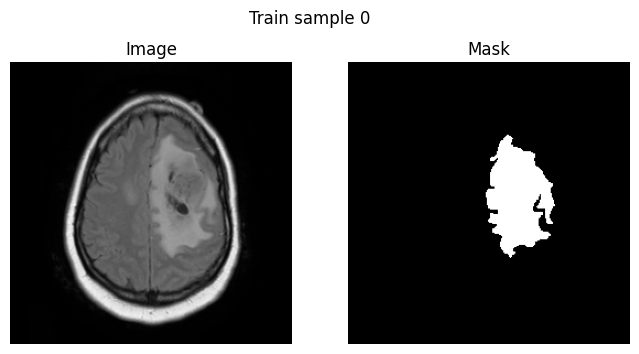

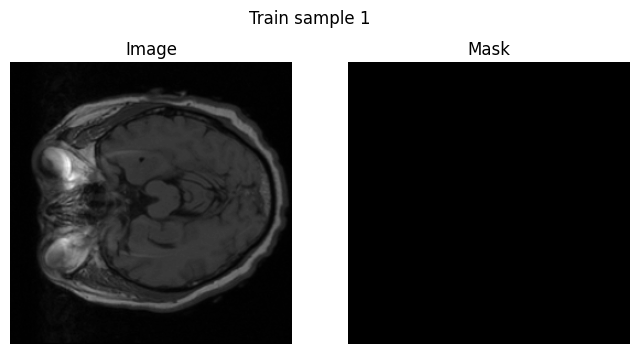

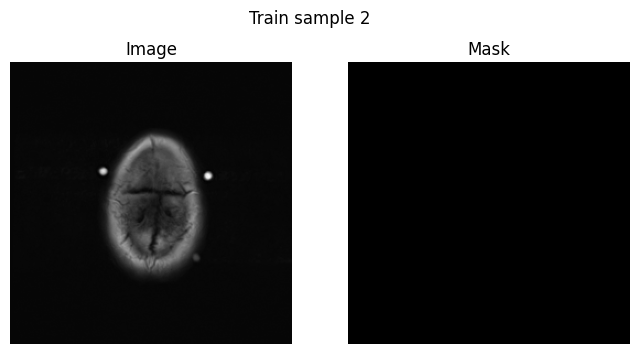

In [8]:
train_gen = MRIDataset(train_pairs, batch_size=BATCH_SIZE, augment=True, shuffle=True)
val_gen = MRIDataset(val_pairs, batch_size=BATCH_SIZE, augment=False, shuffle=False)

# show some examples
x, y = train_gen[0]
print("Batch shapes:", x.shape, y.shape)

def show_sample(img, mask, title=None):
    fig, ax = plt.subplots(1,2, figsize=(8,4))
    ax[0].imshow(img.squeeze(), cmap='gray')
    ax[0].set_title("Image")
    ax[1].imshow(mask.squeeze(), cmap='gray')
    ax[1].set_title("Mask")
    for a in ax:
        a.axis('off')
    if title:
        plt.suptitle(title)
    plt.show()

for i in range(min(3, x.shape[0])):
    show_sample(x[i], y[i], title=f"Train sample {i}")


# 9: UNet builder

A compact UNet with encoder/decoder blocks.


In [9]:
def conv_block(x, filters, kernel_size=3, padding="same", activation="relu"):
    x = layers.Conv2D(filters, kernel_size, padding=padding)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(activation)(x)
    x = layers.Conv2D(filters, kernel_size, padding=padding)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(activation)(x)
    return x

def encoder_block(x, filters):
    c = conv_block(x, filters)
    p = layers.MaxPooling2D((2,2))(c)
    return c, p

def decoder_block(x, skip, filters):
    us = layers.Conv2DTranspose(filters, (2,2), strides=(2,2), padding="same")(x)
    concat = layers.concatenate([us, skip])
    c = conv_block(concat, filters)
    return c

def build_unet(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 1)):
    inputs = layers.Input(shape=input_shape)
    # Encoder
    c1, p1 = encoder_block(inputs, 32)
    c2, p2 = encoder_block(p1, 64)
    c3, p3 = encoder_block(p2, 128)
    c4, p4 = encoder_block(p3, 256)
    # Bottleneck
    bn = conv_block(p4, 512)
    # Decoder
    d1 = decoder_block(bn, c4, 256)
    d2 = decoder_block(d1, c3, 128)
    d3 = decoder_block(d2, c2, 64)
    d4 = decoder_block(d3, c1, 32)
    outputs = layers.Conv2D(1, (1,1), activation="sigmoid")(d4)
    model = keras.Model(inputs, outputs, name="UNet")
    return model

model = build_unet(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 1))
model.summary()


Model: "UNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      9,248 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │     36,928 │ activation_2[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_4[0][0]  

 Total params: 7,771,297 (29.65 MB)

 Trainable params: 7,765,409 (29.62 MB)

 Non-trainable params: 5,888 (23.00 KB)

# 9: Metrics & loss

We define Dice coefficient, Dice loss, and IoU. We'll combine BinaryCrossentropy + DiceLoss for stable training.

In [10]:
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

def iou_metric(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    total = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f)
    union = total - intersection
    return (intersection + smooth) / (union + smooth)

# combined loss
bce = tf.keras.losses.BinaryCrossentropy()
def combined_loss(y_true, y_pred):
    return bce(y_true, y_pred) + dice_loss(y_true, y_pred)

# compile
model.compile(optimizer=keras.optimizers.Adam(1e-4),
              loss=combined_loss,
              metrics=[dice_coef, iou_metric, 'accuracy'])


# 10: Callbacks & train

ModelCheckpoint + ReduceLROnPlateau + EarlyStopping.

In [11]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

CHECKPOINT_PATH = "/kaggle/working/unet_lgg_checkpoint.h5"
checkpoint = ModelCheckpoint(CHECKPOINT_PATH, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, verbose=1, min_lr=1e-7)
early = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)

EPOCHS = 30

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS
)


Epoch 1/30


I0000 00:00:1763646905.779439      66 service.cc:148] XLA service 0x793dec010bc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1763646905.780375      66 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1763646905.780421      66 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1763646907.557338      66 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1763646930.509421      66 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 72/410 ━━━━━━━━━━━━━━━━━━━━ 51s 152ms/step - accuracy: 0.4948 - dice_coef: 0.0230 - iou_metric: 0.0117 - loss: 1.7185

E0000 00:00:1763646949.497701      66 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1763646949.712627      66 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


410/410 ━━━━━━━━━━━━━━━━━━━━ 142s 256ms/step - accuracy: 0.8133 - dice_coef: 0.0248 - iou_metric: 0.0127 - loss: 1.4582 - val_accuracy: 0.9895 - val_dice_coef: 0.0305 - val_iou_metric: 0.0160 - val_loss: 1.1760
Epoch 2/30
410/410 ━━━━━━━━━━━━━━━━━━━━ 78s 190ms/step - accuracy: 0.9809 - dice_coef: 0.0457 - iou_metric: 0.0236 - loss: 1.1481 - val_accuracy: 0.9747 - val_dice_coef: 0.0624 - val_iou_metric: 0.0347 - val_loss: 1.1049
Epoch 3/30
410/410 ━━━━━━━━━━━━━━━━━━━━ 78s 191ms/step - accuracy: 0.9825 - dice_coef: 0.0760 - iou_metric: 0.0403 - loss: 1.0580 - val_accuracy: 0.9306 - val_dice_coef: 0.0870 - val_iou_metric: 0.0501 - val_loss: 1.1432
Epoch 4/30
410/410 ━━━━━━━━━━━━━━━━━━━━ 78s 190ms/step - accuracy: 0.9848 - dice_coef: 0.1499 - iou_metric: 0.0832 - loss: 0.9422 - val_accuracy: 0.9813 - val_dice_coef: 0.1317 - val_iou_metric: 0.0799 - val_loss: 0.9536
Epoch 5/30
410/410 ━━━━━━━━━━━━━━━━━━━━ 79s 192ms/step - accuracy: 0.9877 - dice_coef: 0.2186 - iou_metric: 0.1285 - loss: 0.8

# 11: Plot history

### Plot training curves
Visualize loss, Dice, IoU, and accuracy across epochs.

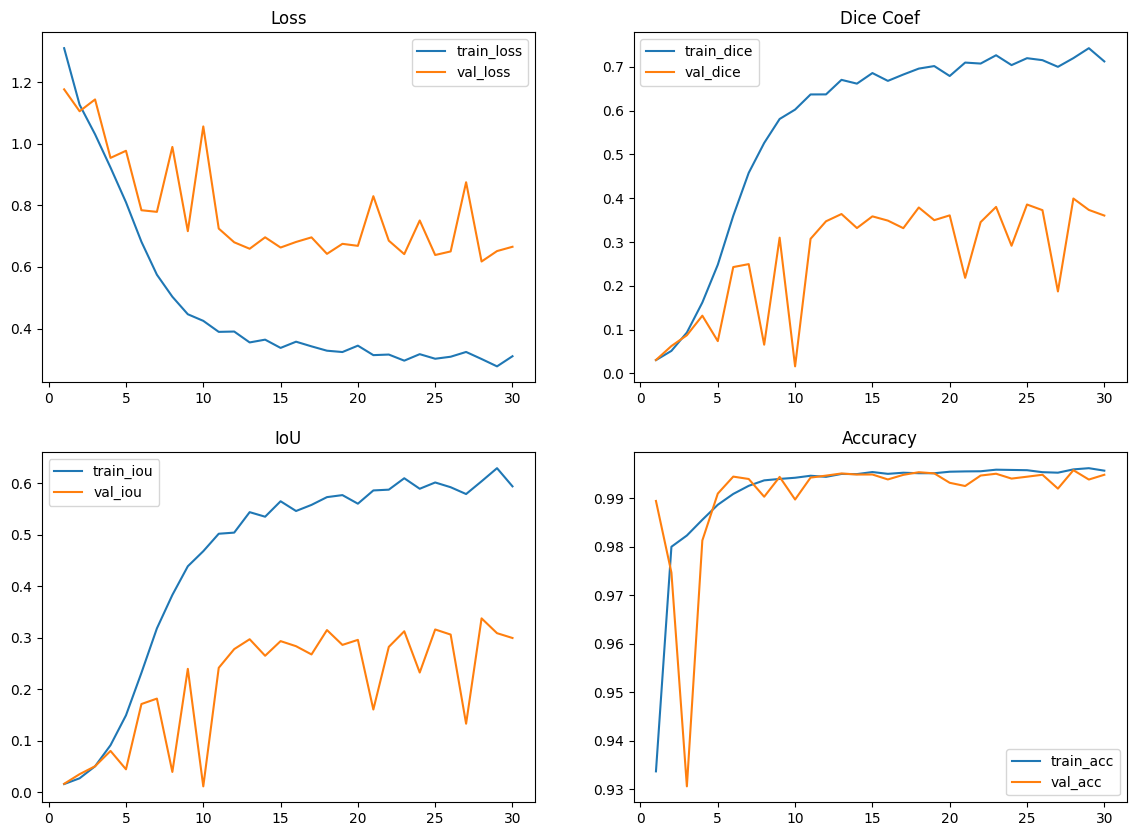

In [12]:
def plot_history(history):
    hist = history.history
    epochs = range(1, len(hist['loss'])+1)
    plt.figure(figsize=(14,10))

    plt.subplot(2,2,1)
    plt.plot(epochs, hist['loss'], label='train_loss')
    plt.plot(epochs, hist['val_loss'], label='val_loss')
    plt.legend(); plt.title('Loss')

    plt.subplot(2,2,2)
    plt.plot(epochs, hist['dice_coef'], label='train_dice')
    plt.plot(epochs, hist['val_dice_coef'], label='val_dice')
    plt.legend(); plt.title('Dice Coef')

    plt.subplot(2,2,3)
    plt.plot(epochs, hist['iou_metric'], label='train_iou')
    plt.plot(epochs, hist['val_iou_metric'], label='val_iou')
    plt.legend(); plt.title('IoU')

    plt.subplot(2,2,4)
    plt.plot(epochs, hist['accuracy'], label='train_acc')
    plt.plot(epochs, hist['val_accuracy'], label='val_acc')
    plt.legend(); plt.title('Accuracy')
    plt.show()

plot_history(history)


# 12: Load best and evaluate

We will load the best checkpoint then evaluate batch-by-batch to compute averaged metrics.

In [13]:
# load best weights 
if os.path.exists(CHECKPOINT_PATH):
    print("Loading best weights from", CHECKPOINT_PATH)
    model.load_weights(CHECKPOINT_PATH)

# aggregate metrics manually over validation set
dice_vals = []
iou_vals = []
acc_vals = []
count = 0

for i in range(len(val_gen)):
    imgs, msks = val_gen[i]
    preds = model.predict(imgs)
    preds_bin = (preds >= 0.5).astype(np.float32)
    # compute per-sample metrics
    for j in range(imgs.shape[0]):
        y_true = msks[j]
        y_pred = preds_bin[j]
        # flatten
        y_true_f = y_true.flatten()
        y_pred_f = y_pred.flatten()
        # dice
        inter = np.sum(y_true_f * y_pred_f)
        dice = (2. * inter + 1e-6) / (np.sum(y_true_f) + np.sum(y_pred_f) + 1e-6)
        # iou
        union = np.sum(y_true_f) + np.sum(y_pred_f) - inter
        iou = (inter + 1e-6) / (union + 1e-6)
        acc = (y_true_f == y_pred_f).mean()
        dice_vals.append(dice)
        iou_vals.append(iou)
        acc_vals.append(acc)
        count += 1

print("Val samples:", count)
print("Mean Dice:", np.mean(dice_vals))
print("Mean IoU:", np.mean(iou_vals))
print("Mean Pixel Accuracy:", np.mean(acc_vals))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━

# 13: Visualize predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


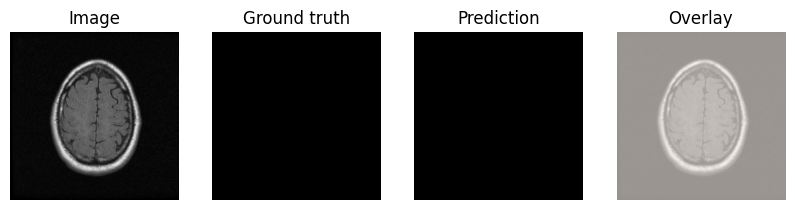

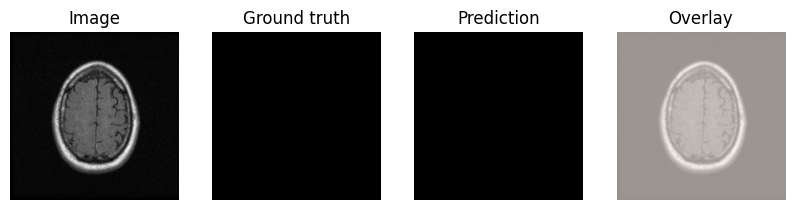

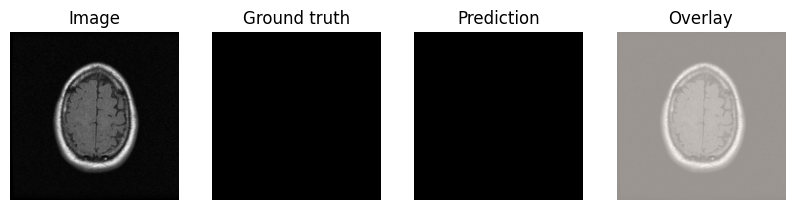

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


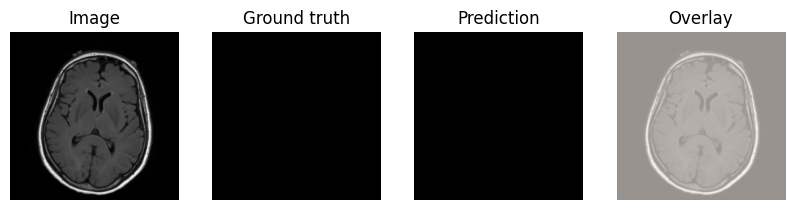

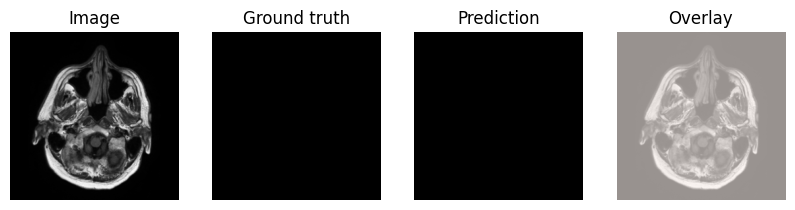

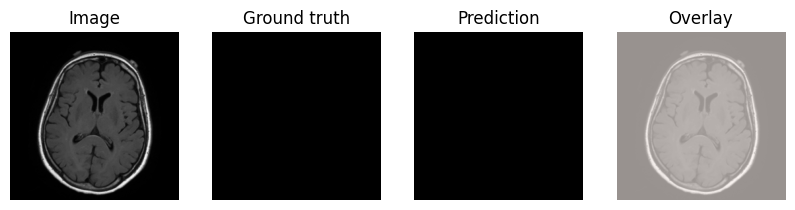

In [14]:
import random
def show_prediction(img, true_mask, pred_mask, alpha=0.6):
    plt.figure(figsize=(10,4))
    plt.subplot(1,4,1)
    plt.imshow(img.squeeze(), cmap='gray'); plt.title("Image"); plt.axis('off')
    plt.subplot(1,4,2)
    plt.imshow(true_mask.squeeze(), cmap='gray'); plt.title("Ground truth"); plt.axis('off')
    plt.subplot(1,4,3)
    plt.imshow(pred_mask.squeeze(), cmap='gray'); plt.title("Prediction"); plt.axis('off')
    plt.subplot(1,4,4)
    plt.imshow(img.squeeze(), cmap='gray'); 
    plt.imshow(pred_mask.squeeze(), alpha=alpha, cmap='Reds'); plt.title("Overlay"); plt.axis('off')
    plt.show()

# pick some random validation samples
n = 6
indices = random.sample(range(len(val_gen)), min(5, len(val_gen)))
count = 0
for idx in indices:
    imgs, msks = val_gen[idx]
    preds = model.predict(imgs)
    preds_bin = (preds >= 0.5).astype(np.float32)
    for i in range(min(3, imgs.shape[0])):
        show_prediction(imgs[i], msks[i], preds_bin[i])
        count += 1
        if count >= n:
            break
    if count >= n:
        break
